Load your Google Drive in the code environment. 

In [1]:
from google.colab import drive
drive.mount('/drive/')

Mounted at /drive/


In [2]:

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 11.1


In [3]:
! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.3 MB/s eta 0:04:16tcmalloc: large alloc 1147494400 bytes == 0x391e2000 @  0x7f3389b37615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:25tcmalloc: large alloc 1434370048 bytes == 0x7d838000 @  0x7f3389b37615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [4]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 20.9 MB/s 


**Check dataset**  

Untar the dataset with people's faces. After this step, you should see a new folder is placed in the folder "GenCyber22_AI_Security". 


In [11]:
import os
!tar -xf "/drive/My Drive/GenCyber22_AI_Security/10classes_50.tar" -C "/drive/My Drive/GenCyber22_AI_Security/"


In [12]:
code_dir = '/drive/My Drive/GenCyber22_AI_Security/'

image_path = f'{code_dir}/10classes_50'

train_data_root = f'{image_path}/train'
test_data_root = f'{image_path}/val'

print('Name of 10 classes (people) are:')
os.listdir(train_data_root)

Name of 10 classes (people) are:


['Ariel_Sharon',
 'Colin_Powell',
 'Donald_Rumsfeld',
 'George_W_Bush',
 'Gerhard_Schroeder',
 'Hugo_Chavez',
 'Jean_Chretien',
 'John_Ashcroft',
 'Junichiro_Koizumi',
 'Tony_Blair']

#load python package

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from facenet_pytorch import InceptionResnetV1

# Training model 

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Let's define some hyper parameters! 

In [15]:
your_batch_size = 12
lr_rate = 0.9
epochs=5

In [16]:
# Data proprocess
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize(160, interpolation=Image.BICUBIC),
    transforms.CenterCrop(160),
    # transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10, resample=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.4287, 0.3769, 0.3361), (0.3024, 0.2754, 0.2672)),
])

transform_test = transforms.Compose([
    transforms.Resize(160, interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.4287, 0.3769, 0.3361), (0.3024, 0.2754, 0.2672)),

])


train_dataset = ImageFolder(train_data_root, transform_train)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=your_batch_size, shuffle=True, num_workers=1, drop_last=False)


test_dataset = ImageFolder(test_data_root, transform_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=your_batch_size, shuffle=True, num_workers=1, drop_last=False)




==> Preparing data..


## Exploring the Data
It is always important to spend a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order. 

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset. 

In [17]:
from locale import normalize
import torchvision
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img, show_original=True):
    #img = img / 2 + 0.5     # unnormalize
    img = img.cpu()
    if show_original:
      image_mean = torch.tensor([0.4287, 0.3769, 0.3361])
      image_std = torch.tensor([0.3024, 0.2754, 0.2672])
      img *= image_std[:,None, None]
      img += image_mean[:,None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    break

Let's view the images without data normalization! 

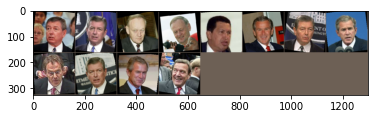

In [18]:
## show images
imshow(torchvision.utils.make_grid(inputs), show_original=True)

Now, what do you see after data normalization? 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


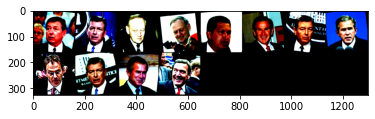

In [19]:
imshow(torchvision.utils.make_grid(inputs), show_original=False)

In [20]:
# https://github.com/timesler/facenet-pytorch
# load pre-trained model
net = InceptionResnetV1(pretrained='vggface2',classify=True, num_classes=10).to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [21]:
# print model structure
print(net)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [22]:
# fix other parameters, only update last layer
for name, param in net.named_parameters():
    param.requires_grad = False
    if 'logits' in name:
        param.requires_grad = True

In [23]:
print("Params to learn:")
for name,param in net.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

Params to learn:
	 logits.weight
	 logits.bias


In [24]:
#define loss function
criterion = nn.CrossEntropyLoss()

In [25]:
#define optimizer
optimizer = optim.Adam(net.parameters(), lr=lr_rate, weight_decay=5e-4)

In [26]:
total_train_loss =[]
total_test_loss = []
total_train_acc=[]
total_test_acc=[]


for epoch in range(epochs):
    print('\nEpoch: %d' % epoch)

    #>>>>>>>>>>>>>>>>>>
    #training
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss=train_loss / (batch_idx + 1)
    avg_acc=100. * correct / total
    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)' % (avg_loss, avg_acc, correct, total))
    total_train_loss.append(avg_loss)
    total_train_acc.append(avg_acc)


    #>>>>>>>>>>>>>>>>>>
    #testing
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


    avg_loss=test_loss / (batch_idx + 1)
    avg_acc=100. * correct / total
    print('Test Loss: %.3f | Acc: %.3f%% (%d/%d)' % (avg_loss, avg_acc, correct, total))
    total_test_loss.append(avg_loss)
    total_test_acc.append(avg_acc)





Epoch: 0
Train Loss: 58.551 | Acc: 68.400% (342/500)
Test Loss: 23.174 | Acc: 85.519% (313/366)

Epoch: 1
Train Loss: 58.210 | Acc: 78.200% (391/500)
Test Loss: 45.717 | Acc: 74.044% (271/366)

Epoch: 2
Train Loss: 63.339 | Acc: 77.000% (385/500)
Test Loss: 20.818 | Acc: 83.880% (307/366)

Epoch: 3
Train Loss: 46.606 | Acc: 80.000% (400/500)
Test Loss: 162.071 | Acc: 52.732% (193/366)

Epoch: 4
Train Loss: 61.384 | Acc: 77.400% (387/500)
Test Loss: 35.826 | Acc: 80.601% (295/366)


## Visualize training result

Text(0, 0.5, 'Acc')

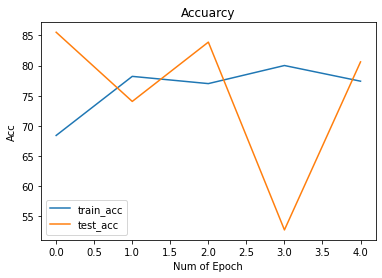

In [27]:
plt.plot(total_train_acc, label='train_acc')
plt.plot(total_test_acc, label='test_acc')
plt.legend()
plt.title('Accuarcy')
plt.xlabel('Num of Epoch')
plt.ylabel('Acc')

Text(0, 0.5, 'Loss')

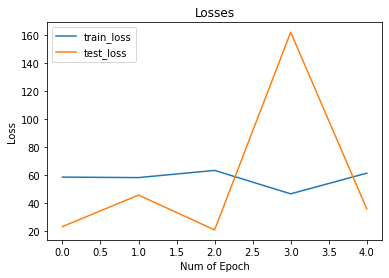

In [28]:

plt.plot(total_train_loss, label='train_loss')
plt.plot(total_test_loss, label='test_loss')
plt.legend()
plt.title('Losses')
plt.xlabel('Num of Epoch')
plt.ylabel('Loss')

Now, let's save the entire model to your code_dir, "GenCyber22_AI_Security". Therefore, we don't need to re-train the model next time. 

In [29]:
torch.save(net, f'{code_dir}/clean_model.pt')
os.listdir(code_dir)

['10classes_50.tar',
 'GenCyber22_backdoor.ipynb',
 'GenCyber22_face_recognition.ipynb',
 '10classes_50',
 'clean_model.pt']